# Mnist 실습

필기체 이미지를 분류하는 간단한 인공지능을 만들어보자. 

![img](https://t1.daumcdn.net/cfile/tistory/22606B435974B30434)


### 숫자 손글씨 인식기 만들기 (Sequential Model을 이용하는 방법)

숫자 손글씨 분류기는 손으로 쓴 숫자 이미지를 입력받으면, 그 이미지가 어떤 숫자를 나타내는지 출력해낼 수 있다. 


> 어떻게 만들어?

일반적으로 딥러닝 기술은 **데이터 준비 -> 딥러닝 네트워크 설계 -> 학습 -> 테스트(평가)**의 순서로 만들게 된다.

## 1. 데이터 준비


### Mnist 숫자 손글씨 Dataset 불러들이기

텐서플로우(Tensorflow)의 표준 API인 `tf.keras`의 **Sequential API**를 이용하여 숫자 손글씨 인식기를 만들어보자. 

구글에서 오픈소스로 제공하는 텐서플로우는 가장 널리 사용되고 있는 머신러닝 라이브러리 중 하나다. 딥러닝 구현 실습은 Tensorflow 버전 2.0 (혹은 그 이상)에서 진행될 예정이다. 


먼저 아래 코드를 실행해보자. 

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

#mnist 로드. 케라스에 내장되어있는 데이터셋
mnist = keras.datasets.mnist

#사전에 다운로드 되어있지 않았다면 다운로드까지 진행
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(len(x_train))

2.2.0
60000


위의 코드를 보면 숫자 손글씨 데이터인 MNIST 데이터셋을 쉽게 읽어들일 수 있다. 
또한 학습 데이터는 60,000개가 있는 것을 확인할 수 있다. 

불러들인 숫자 손글씨 이미지 하나를 출력해보자. MNIST 데이터셋의 X항목은 이미지 데이터를 담는 행렬이고 y항목은 이 이미지에 대한 결과값, 즉 숫자이다.

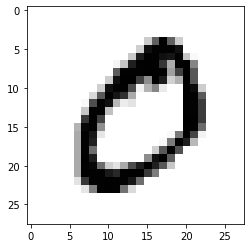

In [3]:
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

숫자 0의 이미지가 나왔다. 이는 x_train\[1\]에 담긴 이미지의 의미는 0이라는 것이다.

마찬가지로 y항목의 내요도 출력해보자.

In [4]:
print(y_train[1])

0


y항목에는 x항목에 들어있는 이미지에 대응하는 실제 숫자값이 담겨있다.

### 학습용 데이터와 시험용 데이터

```python
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```

`mnist.load()` 함수를 통해 학습용 데이터 `(x_train, y_train)`와 시험용 데이터 `(x_test, y_test)`를 나누어서 받아들이는 것을 볼 수 있다. 


In [7]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


학습 데이터는 60000개, 시험 데이터는 10000개가 저장되어있음을 알 수 있다. 저 시험용 데이터는 머신러닝의 학습이 overfitting 되는 것을 방지하기 위해 필요하다.

![img](https://t1.daumcdn.net/cfile/tistory/9951E5445AAE1BE025)

위와 같이 전체 데이터가 있으면 training, test, validation set으로 나눈 것을 볼 수 있다. 모델의 정확도를 미리 예측하고, overfitting을 막고, 여러 머신러닝 모델 중 가장 정확성이 좋은 모델을 선택하기위 validation set을 이용한다.

자세한 내용은 아래 링크 참고!

[Machine Learning에서 validation set을 사용하는 이유](https://3months.tistory.com/118)

### 데이터 전처리 하기

숫자 솔글씨 이미지의 실제 픽셀 값은 0부터 255 사이의 값을 가진다. 

In [8]:
print('최소값 : ', np.min(x_train), '최대값 : ', np.max(x_train))

최소값 :  0 최대값 :  255


인공지능 모델을 훈련시키고 사용할 때, 일반적으로 입력은 0\~1 사이의 값으로 정규화 시켜주는 것이 좋다. MINIST 데이터는 각 픽셀 값이 0~255 사이 범위에 있으므로 데이터들을 255.0으로 나누어 준다.

최소값이 0, 최대값이 1에 근접하도록 나오는지 확인해보자.

In [10]:
x_train_norm, x_test_norm = x_train/255.0, x_test/255.0

print('최소값 : ', np.min(x_train_norm), '최대값 : ', np.max(x_test_norm))

최소값 :  0.0 최대값 :  1.0


## 2. 딥러닝 네트워크 설계하기

### Sequential Model을 사용해보자

데이터가 모두 준비되었다. 이제 딥러닝 네트워크를 만들어 볼 시간이다.

이번에는 텐서플로우 케라스(tf.keras)에서 Sequential API라는 방법을 사용할 것이다. Sequential API는 개발의 자유도는 많이 떨어지지만, 매우 간단하게 딥러닝 모델을 설계할 수 있다. 손쉽게 딥러닝 레이어를 추가할 수 있으며, 케라스에서 모델을 만드는 방법은 Sequential API외에도 Functional API를 이용하는 방법, 밑바닥부터 직접 코딩하는 방법 등이 있다.

아래 코드는 tf.keras에서 Sequential API를 이용하여 **LeNet**이라는 딥러닝 네트워크를 설계한 예시이다. 간단한 코드지만 손글씨 숫자 분류기를 구현하는 데에는 충분하다.

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32,(3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

print("Model에 추가된 Layer 개수 : ", len(model.layers))

Model에 추가된 Layer 개수 :  7
